# Modeling

This notebook only cover the training of the Swin-UNet model.

### Data Loading

In [1]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image

In [2]:
class TumorSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_files = sorted(self.image_dir.glob("*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = Path(self.mask_dir) / img_path.name

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [3]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    # T.Lambda(lambda x: x.repeat(3,1,1))
])

In [4]:
dataset = TumorSegDataset("../data/converted/images", "../data/converted/masks", transform = transform)

### Data Splitting

In [5]:
from torch.utils.data import random_split

In [6]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

In [7]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

### Modeling

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import logging
import math
from os.path import join as pjoin

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
criterion = nn.BCELoss()

In [12]:
def dice_score(preds, targets, smooth = 1e-6):
    """
    Computes Dice Score (per batch).
    preds: tensor, shape (N, C, H, W) after applying sigmoid/softmax or thresholding
    targets: tensor, shape (N, C, H, W) one-hot encoded or same shape as preds
    """
    preds = preds.contiguous().view(preds.shape[0], -1)
    targets = targets.contiguous().view(targets.shape[0], -1)

    intersection = (preds * targets).sum(dim = 1)
    dice = (2. * intersection + smooth) / (preds.sum(dim = 1) + targets.sum(dim = 1) + smooth)
    return dice.mean().item()

In [13]:
def iou_score(preds, targets, smooth=1e-6):
    """
    Computes IoU (Jaccard Index) per batch.
    """
    preds = preds.contiguous().view(preds.shape[0], -1)
    targets = targets.contiguous().view(targets.shape[0], -1)

    intersection = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

##### Swin-UNet

In [14]:
import timm

c:\Users\PC\anaconda3\envs\main-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
swin = timm.create_model('swin_base_patch4_window7_224', pretrained = False, features_only = True)

In [16]:
class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(768, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(384, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(192, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, features):
        e1, e2, e3, e4 = features  # e4 is reduced 512 channels

        d3 = self.up3(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))  # concat 256 + 512 = 768

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))  # concat 128 + 256 = 384

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))  # concat 64 + 128 = 192

        out = F.interpolate(d1, scale_factor=4, mode='bilinear', align_corners=False)
        return torch.sigmoid(self.final(out))


In [17]:
class SwinUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = swin
        self.channel_reducer = nn.Conv2d(1024, 512, kernel_size=1)
        self.decoder = UNetDecoder()

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        features = self.encoder(x)
        features = [self._to_channels_first(f) for f in features]

        features[3] = self.channel_reducer(features[3])

        output = self.decoder(features)
        return output

    def _to_channels_first(self, feature):
        if feature.dim() == 4:
            return feature.permute(0, 3, 1, 2).contiguous()
        elif feature.dim() == 3:
            B, N, C = feature.shape
            H = W = int(N ** 0.5)
            feature = feature.permute(0, 2, 1).contiguous()
            return feature.view(B, C, H, W)
        else:
            raise ValueError(f"Unexpected feature shape: {feature.shape}")


In [18]:
swinunet_model = SwinUNet().to(device)
optimizer = optim.Adam(swinunet_model.parameters(), lr = 1e-4)

In [19]:
best_val_loss = float('inf')
patience = 10
trigger_times = 0

In [20]:
EPOCHS = 100

for epoch in range(EPOCHS):
    swinunet_model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = swinunet_model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    swinunet_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = swinunet_model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(swinunet_model.state_dict(), "../models/swinunet.pth")
    else:
        trigger_times += 1
        print(f"Early Stopping counter: {trigger_times} out of {patience}")
        if trigger_times >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch 1: Train Loss = 0.0831, Val Loss = 0.0636
Epoch 2: Train Loss = 0.0563, Val Loss = 0.0539
Epoch 3: Train Loss = 0.0533, Val Loss = 0.0529
Epoch 4: Train Loss = 0.0522, Val Loss = 0.0532
Early Stopping counter: 1 out of 10
Epoch 5: Train Loss = 0.0510, Val Loss = 0.0511
Epoch 6: Train Loss = 0.0494, Val Loss = 0.0492
Epoch 7: Train Loss = 0.0475, Val Loss = 0.0512
Early Stopping counter: 1 out of 10
Epoch 8: Train Loss = 0.0456, Val Loss = 0.0476
Epoch 9: Train Loss = 0.0429, Val Loss = 0.0442
Epoch 10: Train Loss = 0.0392, Val Loss = 0.0375
Epoch 11: Train Loss = 0.0380, Val Loss = 0.0374
Epoch 12: Train Loss = 0.0356, Val Loss = 0.0356
Epoch 13: Train Loss = 0.0336, Val Loss = 0.0332
Epoch 14: Train Loss = 0.0311, Val Loss = 0.0326
Epoch 15: Train Loss = 0.0306, Val Loss = 0.0322
Epoch 16: Train Loss = 0.0289, Val Loss = 0.0295
Epoch 17: Train Loss = 0.0267, Val Loss = 0.0290
Epoch 18: Train Loss = 0.0252, Val Loss = 0.0310
Early Stopping counter: 1 out of 10
Epoch 19: Train Los

In [21]:
swinunet_model.eval()
dice_total = 0
iou_total = 0
num_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = swinunet_model(images)

        if outputs.shape[1] == 1:  # Binary segmentation
            # probs = torch.sigmoid(outputs)
            probs = outputs
            preds = (probs > 0.5).float()
            targets = (masks > 0.5).float()
        else:  # Multiclass segmentation
            preds = torch.argmax(outputs, dim = 1)  # (N, H, W)
            targets = masks.long().squeeze(1)     # (N, H, W)

            # Convert preds and targets to one-hot for Dice and IoU
            preds = torch.nn.functional.one_hot(preds, num_classes=outputs.shape[1])  # (N,H,W,C)
            preds = preds.permute(0, 3, 1, 2).float()  # (N,C,H,W)
            targets = torch.nn.functional.one_hot(targets, num_classes=outputs.shape[1])
            targets = targets.permute(0, 3, 1, 2).float()

        dice = dice_score(preds, targets)
        iou = iou_score(preds, targets)

        dice_total += dice
        iou_total += iou
        num_batches += 1

print(f"Test Dice Score: {dice_total / num_batches:.4f}")
print(f"Test IoU Score: {iou_total / num_batches:.4f}")

Test Dice Score: 0.7161
Test IoU Score: 0.6291


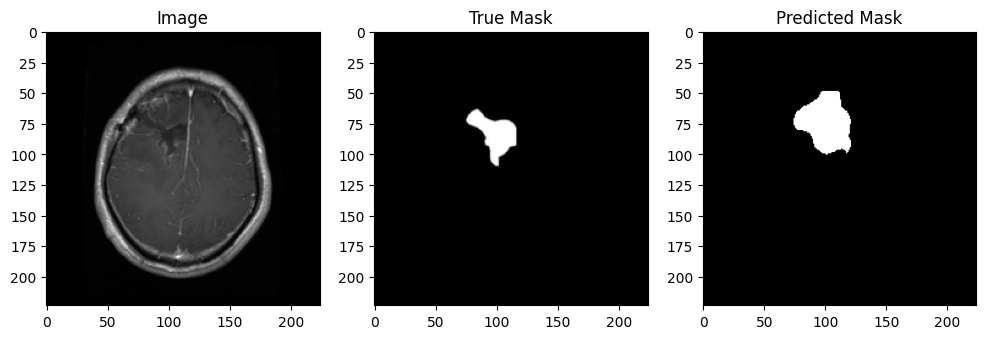

In [25]:
swinunet_model.eval()
with torch.no_grad():
    sample_img, sample_mask = test_dataset[3]
    pred = swinunet_model(sample_img.unsqueeze(0).to(device)).cpu().squeeze().numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.subplot(1,3,2)
    plt.title("True Mask")
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred > 0.5, cmap='gray')
    plt.show()